### Scrape data
---

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import snscrape.modules.twitter as sntwitter
import seaborn as sns

from nltk.corpus import stopwords, words # get stopwords from NLTK library & get all words in english language
from nltk.tokenize import word_tokenize # to create word tokens
# from nltk.stem import PorterStemmer (I played around with Stemmer and decided to use Lemmatizer instead)
from nltk.stem import WordNetLemmatizer # to reduce words to orginal form
from nltk import pos_tag # For Parts of Speech tagging

In [4]:
query = '(France OR Brazil OR Argentina OR England OR Portugal OR #WorldCupFrance OR #WorldCupBrazil OR #WorldCupArgentine OR #WorldCupEngland OR #WorldCupPortugal)lang:en since:2022-11-20 until:2022-12-05 '

tweets = []

for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i > 50000:
        break
    else:
        tweets.append([tweet.date, tweet.id, tweet.url, tweet.user.username, tweet.user.location,
                       tweet.content, tweet.likeCount, tweet.retweetCount, tweet.sourceLabel])
df = pd.DataFrame(tweets, columns= ['Date', 'ID', 'url', 'user_name', 'location', 'content', 'likes', 'retweet', 'source'])
df.to_csv('twitter.csv', mode='a')  

In [6]:
df1 = pd.read_csv('/home/miki/Desktop/Projects/Hamoye/twitter-sentiment-analysis/data/raw/player.csv', encoding='unicode_escape')
df1.head(15)

,Unnamed: 0,Date,ID,url,user_name,location,content,likes,retweet,source
0,0,2022-12-04 22:57:52+00:00,1599538508061777920,https://twitter.com/isma1111111111/status/1599...,isma1111111111,NaN,@Wilko_666 @RBartholonew @Blevi1989 @GNev2 Wha...,0,0,Twitter for iPhone
1,1,2022-12-04 22:02:20+00:00,1599524529167945729,https://twitter.com/TheRoom442/status/15995245...,TheRoom442,"Toronto, Ontario",Room 442 World Cup post-show is LIVE!\n\nð«ð...,16,6,Twitter Web App
2,2,2022-12-04 21:29:43+00:00,1599516321913671682,https://twitter.com/showlove34/status/15995163...,showlove34,NaN,@DigosonJaypee @TimelineCR7 @jnrcrook Lol\nToo...,2,0,Twitter for iPhone
3,3,2022-12-04 20:42:09+00:00,1599504350375616512,https://twitter.com/ErykLama/status/1599504350...,ErykLama,Norwich / Newcastle â¢ UK,What does Gareth Southgate have against James ...,2,0,Twitter for iPhone
4,4,2022-12-04 19:43:14+00:00,1599489525033881600,https://twitter.com/Jmanriquez_21/status/15994...,Jmanriquez_21,"Los Angeles, CA",@Dannyykun @RishabB25 @ESPNFC Champions league...,0,0,Twitter for iPhone
5,5,2022-12-04 19:41:59+00:00,1599489208879828993,https://twitter.com/satocis/status/15994892088...,satocis,"Rio de Janeiro, Brazil",@philipplahm @GaryLineker @OnsOranje @Argentin...,3,0,Twitter for iPhone
6,6,2022-12-04 19:27:15+00:00,1599485501022425088,https://twitter.com/Aluwani29772477/status/159...,Aluwani29772477,NaN,@Joepessel @ClinicaIKylian @ESPNFC He is alrea...,0,0,Twitter for Android
7,7,2022-12-04 18:04:16+00:00,1599464620842176512,https://twitter.com/AbiolaI16976171/status/159...,AbiolaI16976171,Lagos Nigeria,@klausfrey @Bayo_ETH @sportbible Do u even kno...,1,0,Twitter for Android
8,8,2022-12-04 17:40:10+00:00,1599458553764679680,https://twitter.com/haksjjzhahajkw/status/1599...,haksjjzhahajkw,NaN,@cr7raprhymes Can't put Ronaldo in the convers...,5,0,Twitter for Android
9,9,2022-12-04 17:30:41+00:00,1599456169377947648,https://twitter.com/thesoccereye/status/159945...,thesoccereye,NaN,Describe Kylian Mbappe in one sentence? Thunde...,1,0,Twitter for Android


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  338 non-null    int64 
 1   Date        338 non-null    object
 2   ID          338 non-null    int64 
 3   url         338 non-null    object
 4   user_name   338 non-null    object
 5   location    197 non-null    object
 6   content     338 non-null    object
 7   likes       338 non-null    int64 
 8   retweet     338 non-null    int64 
 9   source      338 non-null    object
dtypes: int64(4), object(6)
memory usage: 26.5+ KB


In [8]:
pd.DataFrame({'Missing Values %': df1.isnull().sum()/len(df1.index)*100})

,Missing Values %
Unnamed: 0,0.000000
Date,0.000000
ID,0.000000
url,0.000000
user_name,0.000000
location,41.715976
content,0.000000
likes,0.000000
retweet,0.000000
source,0.000000


### Data Pre-Processing
---

In [9]:
df1['location'] = df1['location'].fillna('unknown')

In [10]:
import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline

In [11]:
eng_stop_words = list(stopwords.words('english'))
emoji = list(UNICODE_EMOJI.keys())

In [12]:
# function for preprocessing tweet in preparation for sentiment analysis
def ProcessedTweets(text):
    #changing tweet text to small letters
    text = text.lower()
    # Removing @ and links 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    # removing repeating characters
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    # removing punctuation and numbers
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words and removing stop words from the tweet text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [13]:
df1['Tweets'] = df1['content'].apply(ProcessedTweets)

In [15]:
df1.head(300)

,Unnamed: 0,Date,ID,url,user_name,location,content,likes,retweet,source,Tweets
0,0,2022-12-04 22:57:52+00:00,1599538508061777920,https://twitter.com/isma1111111111/status/1599...,isma1111111111,unknown,@Wilko_666 @RBartholonew @Blevi1989 @GNev2 Wha...,0,0,Twitter for iPhone,heâs best rw world outperforming foden past ...
1,1,2022-12-04 22:02:20+00:00,1599524529167945729,https://twitter.com/TheRoom442/status/15995245...,TheRoom442,"Toronto, Ontario",Room 442 World Cup post-show is LIVE!\n\nð«ð...,16,6,Twitter Web App,room world cup postshow live ð « ð mbappe ...
2,2,2022-12-04 21:29:43+00:00,1599516321913671682,https://twitter.com/showlove34/status/15995163...,showlove34,unknown,@DigosonJaypee @TimelineCR7 @jnrcrook Lol\nToo...,2,0,Twitter for iPhone,lol much age even player already ml scored juv...
3,3,2022-12-04 20:42:09+00:00,1599504350375616512,https://twitter.com/ErykLama/status/1599504350...,ErykLama,Norwich / Newcastle â¢ UK,What does Gareth Southgate have against James ...,2,0,Twitter for iPhone,gareth southgate james maddison best premier l...
4,4,2022-12-04 19:43:14+00:00,1599489525033881600,https://twitter.com/Jmanriquez_21/status/15994...,Jmanriquez_21,"Los Angeles, CA",@Dannyykun @RishabB25 @ESPNFC Champions league...,0,0,Twitter for iPhone,champion league also best team world cup doesn...
...,...,...,...,...,...,...,...,...,...,...,...
295,295,2022-11-21 17:08:19+00:00,1594739494758060035,https://twitter.com/njny/status/15947394947580...,njny,The Diaspora,Actually a really good question I hadn't thoug...,0,0,Twitter Web App,actually really good question hadnt thought wh...
296,296,2022-11-21 15:44:33+00:00,1594718416832811010,https://twitter.com/Pacifique_Nteta/status/159...,Pacifique_Nteta,"Pretoria, SA / Lubumbashi, DRC",The La Liga app also provides updates and resu...,0,0,Twitter for Android,la liga app also provides update result world ...
297,297,2022-11-21 15:33:30+00:00,1594715635770351617,https://twitter.com/WonderMahlobo/status/15947...,WonderMahlobo,JOHUSTLEBURG,The only way the best players in the world ar...,7,1,Twitter for Android,way best player world missing world cup injury...
298,298,2022-11-21 14:43:57+00:00,1594703166368456705,https://twitter.com/BinayaJyoti/status/1594703...,BinayaJyoti,unknown,who will be the best young player of this worl...,1,0,Twitter for Android,best young player world cup vini jr ð¤ oppss...


In [12]:
tweets_string = df1['Tweets'].tolist()
tweets_string = " ".join(tweets_string)

In [13]:
import random

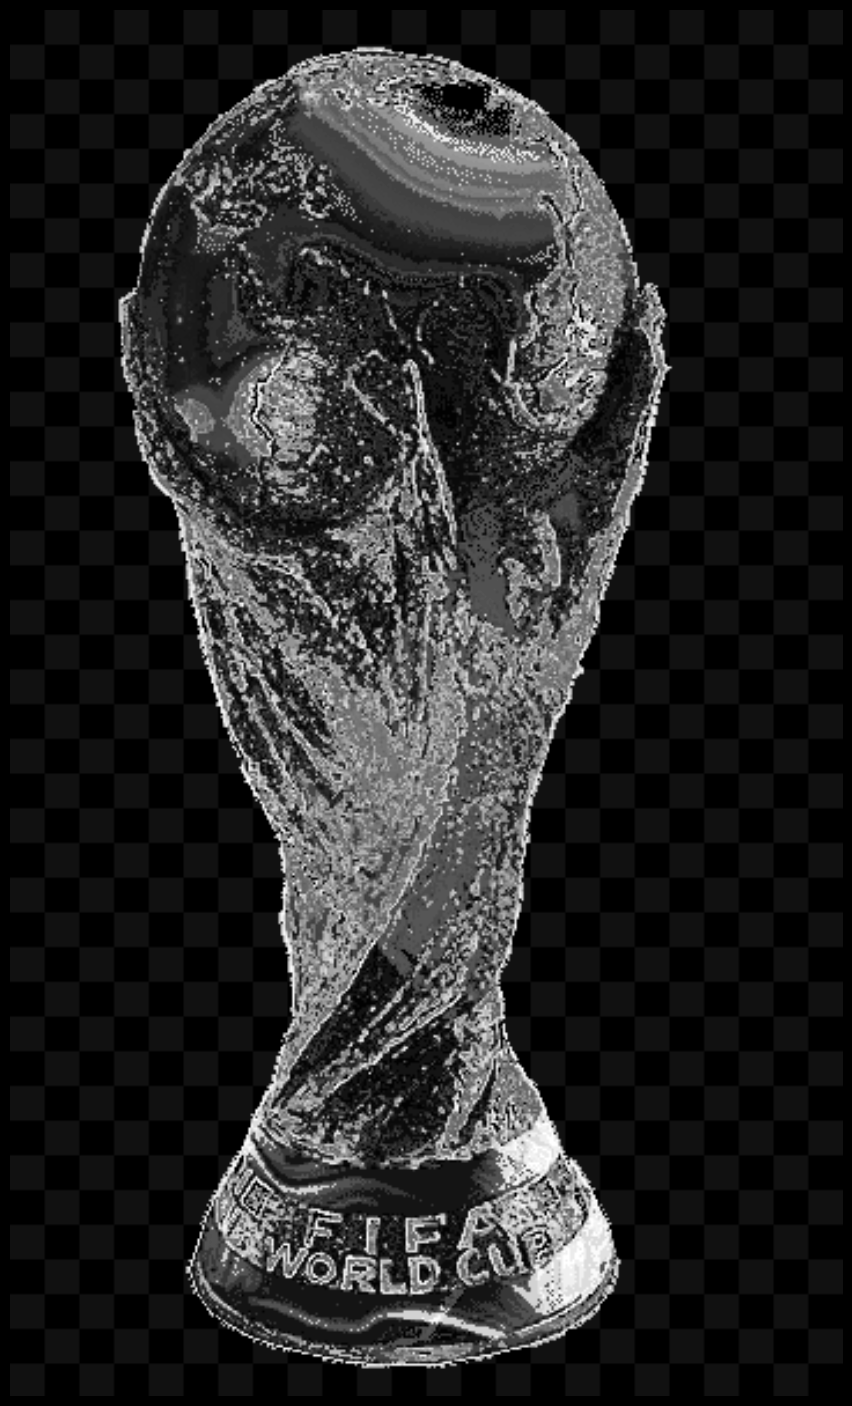

In [14]:
# Import Twitter Logo
image = np.array(Image.open('/home/miki/Desktop/Projects/Hamoye/twitter-sentiment-analysis/static/cup.png'))
    
fig = plt.figure() # Instantiate the figure object
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(image, cmap=plt.cm.gray, interpolation='bilinear') # Display data as an image
plt.axis('off') # Remove axis
plt.show() # Display image

In [15]:
# Displaying the most talked about word in a word cloud 
# some stop words were still evident but was removed during visualization on Power BI
# Instantiate the Twitter word cloud object
w_cloud = WordCloud(background_color='white', max_words=1500, mask=image).generate(tweets_string)

# Display the generated Word Cloud
# plt.imshow(w_cloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

In [16]:

def blue_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(210, 100%%, %d%%)" % random.randint(50, 70)

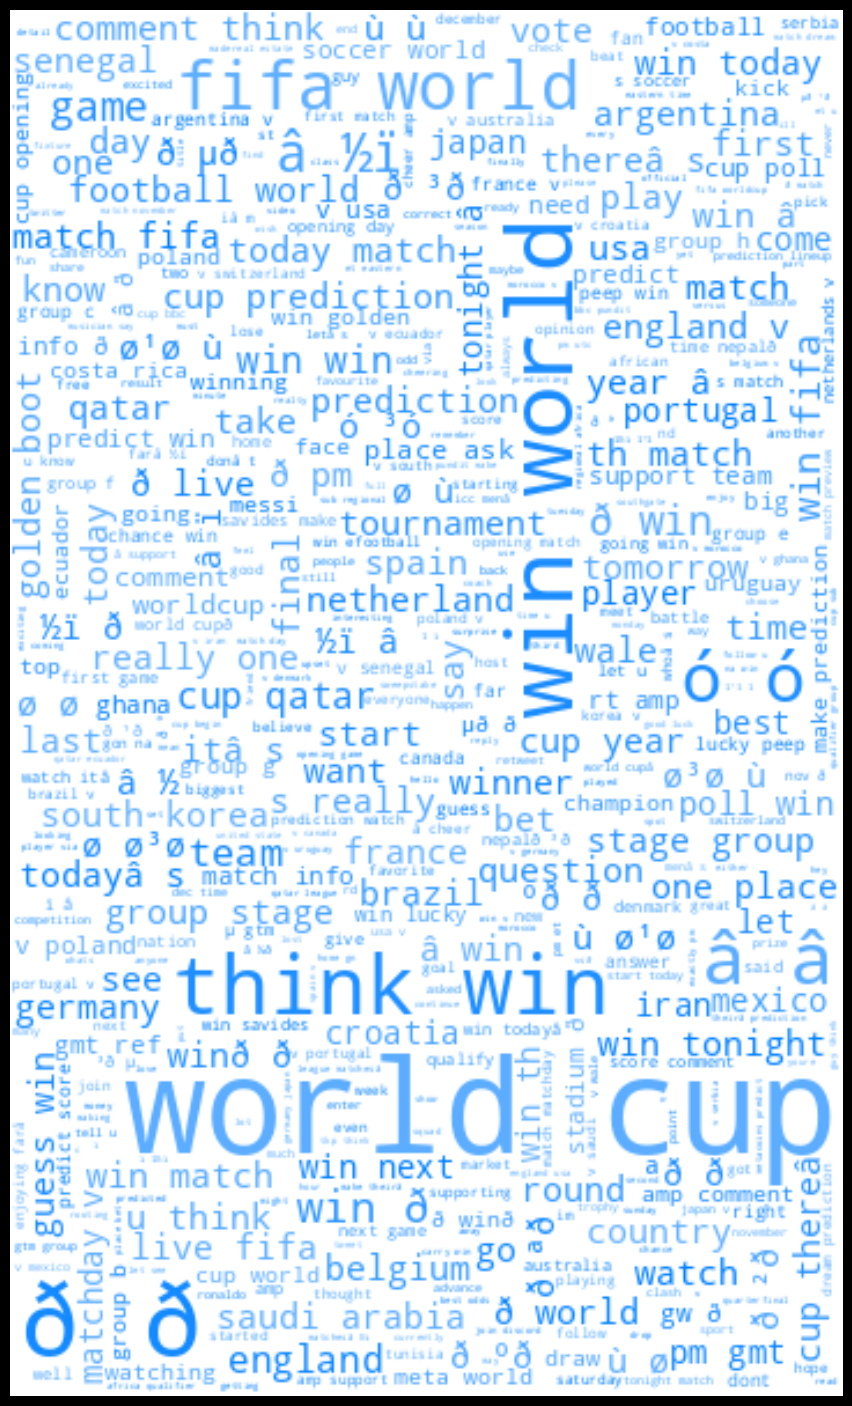

In [17]:
# # Instantiate the Twitter word cloud object
# twitter_wc = WordCloud(background_color='white', max_words=1500, mask=image)

# # generate the word cloud
# twitter_wc.generate(tweets_long_string)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14)  # set width
fig.set_figheight(18)  # set height

plt.imshow(w_cloud.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis('off')
plt.show()